In [1]:
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [220]:
import boto3
import io
import pandas as pd

def retrieveProductsInfo(client, bucket, inventory_key):

    csv_inventory = client.get_object(Bucket=bucket, Key=inventory_key)
    df = pd.read_csv(io.BytesIO(csv_inventory['Body'].read()))

    products = {}

    for row in df.iterrows():
#         print('row',row[1])
        prod = {}
        prod_name = row[1]['sku']
        for key in row[1].keys():
            if key != 'sku':
                prod[key] = row[1][key]
        products[prod_name] = prod
        
    print('products: ',products)
#         for col in row[1]:
#             print('col',col)
#     for column in df:
#         print(df[column])
        


client = boto3.client('s3')
retrieveProductsInfo(client, 'supplychain-enkidoo', 'test-files/inventory_002.csv')


products:  {'Product_2167': {'quantity': 0, 'cost': 175, 'price': 500}, 'Product_0677': {'quantity': 0, 'cost': 12, 'price': 50}, 'Product_0011': {'quantity': 0, 'cost': 10, 'price': 40}, 'Product_1436': {'quantity': 0, 'cost': 50, 'price': 150}, 'Product_1025': {'quantity': 0, 'cost': 5, 'price': 20}}


In [206]:
demand = np.array([80, 65, 20, 50, 90, 80, 60, 25, 70, 30, 40, 75])
skutest = Item(K=100, h=0.35, U=7, S=25, L=2,
               period='W', length=12, inventory=500)
skutest.update_demand(demand)


fixed [40 30 40 75]
demand: [40 30 40 75]
order_qty [ 110.    0.    0.   75.]
order recep [   0.    0.    0.    0.    0.    0.    0.    0.  110.    0.    0.   75.]
purchase_order [   0.    0.    0.    0.    0.    0.  110.    0.    0.   75.    0.    0.]
Analysis results:
EOQ -------- revenues:  13589.5
JIT -------- revenues:  14965.0
SilverMeal - revenues:  14965.0
sm [   0.    0.    0.    0.    0.    0.  110.    0.    0.   75.    0.    0.]


In [207]:
def silver_meal(planned_demand, K, h):
    print('demand:',planned_demand)
    # initialize parameters
    n = len(planned_demand)
    cpp = [K]  # cost per period
    j = 0
    order_idx = []

    # SM heuristic
    for i in range(n-1):
        cpp.append((j+1)/(j+2) * (cpp[j] + h*planned_demand[i+1]))
        j += 1

        if cpp[j] > cpp[j-1]:
            order_idx.append(i+1)
            # start per-period analysis over since an order has been scheduled
            cpp = [K]
            j = 0

    # compute quantities to order
    order_qty = np.zeros(n)
    prev_idx = 0
    order_idx.append(n)

    for idx in order_idx:
        order_qty[prev_idx] = np.sum(planned_demand[prev_idx:idx])
        prev_idx = idx

    print('order_qty',order_qty)
    return order_qty


def silver_meal_purchase_orders(item, planned_demand):

    order_receipt = np.zeros(item.length)
    purchase_order = np.zeros(item.length)
    
    pen_idx = -1
    # Find next penury in sight
    for i in range(item.length):
        penury = item.current_inventory - np.sum(planned_demand[:i+1])
        if penury < 0:
            pen_idx = i
            break
    
    if pen_idx is not -1:
        start_sm_idx = max(item.L,pen_idx) 
    else:
        # no penury in sight
        return [order_receipt, purchase_order]  
    
    # if penury is after lead, there will be leftovers, so we must compensate for SM does not take inventory leftovers in account
    fixed_demand = planned_demand[start_sm_idx:] if pen_idx < item.L else np.insert(planned_demand[start_sm_idx+1:],0,-penury)
    
    SM = silver_meal(fixed_demand, item.K, item.h)
    
    order_receipt = np.concatenate([start_sm_idx * [0], SM])
    order_receipt[:item.L] = 0
    
    purchase_order = np.roll(order_receipt, -item.L)
    purchase_order[-item.L:] = 0
    
    return [order_receipt, purchase_order]    

In [105]:
class Planner:

    def __init__(self, item, planning_function):

        # cost arrays
        self.item = item
        self.revenues = np.zeros(item.length)
        self.holding_cost = np.zeros(item.length)
        self.setup_cost = np.zeros(item.length)
        self.ordering_cost = np.zeros(item.length)
        self.lost_sales = np.zeros(item.length)
        self.total_revenues = np.zeros(item.length)

        self.planner = planning_function

    def _inventory_levels(self, planned_demand):
        self.ending_balance = np.zeros(self.item.length)
        I = np.zeros(self.item.length + 1)
        I[0] = self.item.current_inventory
        for i in range(self.item.length):
            self.ending_balance[i] = I[i] + \
                self.order_receipt[i] - planned_demand[i]
            I[i+1] = np.maximum(self.ending_balance[i], 0)
        self.inventory_levels = I[1:]

    def _costs(self, planned_demand):
        self.holding_cost = self.item.h * self.inventory_levels
        self.setup_cost = self.item.K * np.heaviside(self.purchase_order, 0)
        self.ordering_cost = self.item.U * self.purchase_order
        self.revenues = self.item.S * \
            np.minimum(planned_demand, planned_demand + self.ending_balance)
        self.lost_sales = np.minimum(self.item.S * self.ending_balance, 0)

        self.total_revenues = np.sum(self.revenues + self.lost_sales -
                                     (self.holding_cost + self.setup_cost + self.ordering_cost))

    def update_demand(self, planned_demand):
        [self.order_receipt, self.purchase_order] = self.planner(
            self.item, planned_demand)
        self._inventory_levels(planned_demand)
        self._costs(planned_demand)

    def getRevenues(self):
        return self.total_revenues

    def getPurchase(self):
        return self.purchase_order


In [103]:
class Item:
    
    # Initializer/Instance Attributes
    def __init__(self, K, h, U, S, L, period, length, inventory):
        self.K = K # setup cost; cost per order
        self.h = h # holding cost per unit per period
        self.U = U # unit cost
        self.S = S # sale cost
        self.L = L # lead time
        self.period = period # 'W' or 'M'
        self.length = length
        
        self.current_inventory = inventory
        
        self.eoq_planner = Planner(self, eoq_purchase_orders)
        self.jit_planner = Planner(self, jit_purchase_orders)
        self.sm_planner = Planner(self, silver_meal_purchase_orders)
        
        # cost arrays
        self.revenues = np.zeros(self.length)
        self.holding_cost = np.zeros(self.length)
        self.setup_cost = np.zeros(self.length)
        self.ordering_cost = np.zeros(self.length)
        self.lost_sales = np.zeros(self.length)
        self.total_revenues = np.zeros(self.length)
        
        self.firstPlanner = Planner(self, randomPlanner)
        
    def _silver_meal(self, planned_demand):
        # initialize parameters
        n = len(planned_demand)
        cpp = [self.K] # cost per period
        j = 0
        order_idx = []
    
        # SM heuristic
        for i in range(n-1):
            cpp.append((j+1)/(j+2) * (cpp[j] + self.h*planned_demand[i+1]))
            j += 1
                   
            if cpp[j] > cpp[j-1]:
                order_idx.append(i+1)
                # start per-period analysis over since an order has been scheduled
                cpp = [self.K]
                j = 0 
    
        # compute quantities to order
        order_qty = np.zeros(n)
        prev_idx = 0
        order_idx.append(n)
    
        for idx in order_idx:
            order_qty[prev_idx] = np.sum(planned_demand[prev_idx:idx])
            prev_idx = idx
    
        return order_qty
    
    def _purchase_orders(self, planned_demand):
        
        for i in range(self.length):
            penury = self.current_inventory - np.sum(planned_demand[:i+1])
            if penury < 0:
                pen_idx = i
                break
        SM = self._silver_meal(planned_demand[pen_idx:])
        
        # Case 1: stockout happens before our chance to replenish inventory (lead time too large)
        if self.L + len(SM) + 1 > self.length: # stockout inevitable
            self.order_receipt = np.concatenate([ pen_idx * [0], SM ])
            self.order_receipt[:self.L] = 0 # stockout is inevitable so we cannot order in time
            self.purchase_order = np.roll(self.order_receipt, -self.L)
            self.purchase_order[-self.L:] = 0
            if self.purchase_order[0] == 0: # then do just in time until next order arrives
                idx = next((index for index, value in enumerate(self.purchase_order) if value != 0), None)
                self.order_receipt[self.L] = np.sum(planned_demand[self.L:idx+self.L])  
                self.purchase_order[0] = self.order_receipt[self.L]
        else:
        # Case 2: we have time to replenish the inventory before the stockout happens
            self.order_receipt = self._silver_meal(planned_demand)
            self.order_receipt[:self.L] = 0 # we don't have time to order these quantities
            #patch here as this causes the algorithm not to be optimal
            self.purchase_order = np.concatenate([self.order_receipt[self.L:], self.L * [0]])
    
    def _inventory_levels(self, planned_demand):
        self.ending_balance = np.zeros(self.length)
        I = np.zeros(self.length + 1)
        I[0] = self.current_inventory
        for i in range(self.length):
            self.ending_balance[i] = I[i] + self.order_receipt[i] - planned_demand[i]
            I[i+1] = np.maximum(self.ending_balance[i], 0)
        self.inventory_levels = I[1:]
    
    def _costs(self, planned_demand):
        self.holding_cost = self.h * self.inventory_levels
        self.setup_cost = self.K * np.heaviside(self.purchase_order, 0)
        self.ordering_cost = self.U * self.purchase_order
        self.revenues = self.S * np.minimum(planned_demand, planned_demand + self.ending_balance)
        self.lost_sales = np.minimum(self.S * self.ending_balance, 0)
        
        self.total_revenues = np.sum(self.revenues + self.lost_sales - 
                                    (self.holding_cost + self.setup_cost + self.ordering_cost))
        
    def _eoq(self, planned_demand):
        avg_forecast = np.average(planned_demand)
        print(avg_forecast)
        self.eoq = np.sqrt(2*self.K*avg_forecast/self.h)        
        
        
    def update_demand(self, planned_demand):
        self.eoq_planner.update_demand(planned_demand)
        self.jit_planner.update_demand(planned_demand)
        self.sm_planner.update_demand(planned_demand)

        print('Analysis results:')
        print('EOQ -------- revenues: ', self.eoq_planner.getRevenues())
        print('JIT -------- revenues: ', self.jit_planner.getRevenues())
        print('SilverMeal - revenues: ', self.sm_planner.getRevenues())

        print('sm', self.sm_planner.getPurchase())
        #self._purchase_orders(planned_demand)
        #self._inventory_levels(planned_demand)
        #self._costs(planned_demand)
        

In [100]:
skutest = Item(K=100, h=0.35, U=7, S=25, L=2, period='W', length=12, inventory=180)

skutest.jit_planner.update_demand(demand)
skutest.jit_planner.purchase_order
skutest.jit_planner.total_revenues

comble:  35.0
comble:  90.0
comble:  80.0
comble:  60.0
comble:  25.0
comble:  70.0
comble:  30.0
comble:  40.0
comble:  75.0
periods:  1  purchases:  [  0.  35.  90.  80.  60.  25.  70.  30.  40.  75.   0.   0.]
comble:  35.0
comble:  80.0
comble:  25.0
comble:  30.0
comble:  75.0
periods:  2  purchases:  [   0.  125.    0.  140.    0.   95.    0.   70.    0.   75.    0.    0.]
comble:  35.0
comble:  60.0
comble:  30.0
periods:  3  purchases:  [   0.  205.    0.    0.  155.    0.    0.  145.    0.    0.    0.    0.]


array([   0.,  205.,    0.,    0.,  155.,    0.,    0.,  145.,    0.,
          0.,    0.,    0.])

13025.75

In [88]:
i=0
number_of_periods = 2
demand
demand[i+1:i+1+number_of_periods]
np.sum(demand[i:i+number_of_periods])

array([80, 65, 20, 50, 90, 80, 60, 25, 70, 30, 40, 75])

array([65, 20])

145

In [62]:
def eoq_purchase_orders(item, planned_demand):

    order_receipt = np.zeros(item.length)
    purchase_order = np.zeros(item.length)

    avg_forecast = np.average(planned_demand)
    eoq_value = np.round(np.sqrt(2*item.K*avg_forecast/item.h))
    
    for i in range(item.length):
        backInTime = i-item.L
        if backInTime < 0:
            continue
        received_index = max(backInTime, 0)
        coming_demand = np.sum(planned_demand[:i+1])
        coming_receipt = np.sum(purchase_order[:received_index])
        if coming_demand > coming_receipt+item.current_inventory:
            purchase_order[backInTime] = eoq_value

        order_receipt[i] = purchase_order[backInTime]

    return [order_receipt, purchase_order]


In [175]:
def jit_purchase_orders(item, planned_demand):

    max_revenues = -float('inf')
    better_config = []
    # as we don't know if just in time will be how many periods, will optimize it on 1,2 and 3
    for i in range(1,4):
        [order_receipt, purchase_order] = jit_purchase_orders_per_periods(
            item, planned_demand, i)
        # do _inventory_levels and _costs computing for optimization
        ending_balance = np.zeros(item.length)
        I = np.zeros(item.length + 1)
        I[0] = item.current_inventory
        for i in range(item.length):
            ending_balance[i] = I[i] + \
                order_receipt[i] - planned_demand[i]
            I[i+1] = np.maximum(ending_balance[i], 0)
        inventory_levels = I[1:]
        holding_cost = item.h * inventory_levels
        setup_cost = item.K * np.heaviside(purchase_order, 0)
        ordering_cost = item.U * purchase_order
        revenues = item.S * \
            np.minimum(planned_demand, planned_demand + ending_balance)
        lost_sales = np.minimum(item.S * ending_balance, 0)

        total_revenues = np.sum(revenues + lost_sales -
                                (holding_cost + setup_cost + ordering_cost))

        if total_revenues > max_revenues:
            better_config = [order_receipt, purchase_order]
    return better_config


def jit_purchase_orders_per_periods(item, planned_demand, number_of_periods):
    order_receipt = np.zeros(item.length)
    purchase_order = np.zeros(item.length)

    for i in range(item.length):
        backInTime = i-item.L
        if backInTime < 0:  # cannot add purchase order before now
            continue
        received_index = max(backInTime, 0)
        coming_demand = np.sum(planned_demand[:i+1])
        coming_receipt = np.sum(purchase_order[:received_index])
        if coming_demand > coming_receipt+item.current_inventory:
            comble = coming_demand - (coming_receipt+item.current_inventory)
            order_qty = np.sum(planned_demand[i+1:i+number_of_periods]) + comble
            purchase_order[backInTime] = order_qty

        order_receipt[i] = purchase_order[backInTime]

    return [order_receipt, purchase_order]

In [50]:
np.sum(demand[2:])

540

In [63]:
demand = np.array([80, 65, 20, 50, 90, 80, 60, 25, 70, 30, 40, 75])
[order, purchase] = eoq_purchase_orders(skutest, demand)
print('orders:',order)
print('purchases:',purchase)

orders: [   0.    0.    0.  181.    0.  181.    0.    0.    0.  181.    0.    0.]
purchases: [   0.  181.    0.  181.    0.    0.    0.  181.    0.    0.    0.    0.]


In [12]:
demand = np.array([80, 65, 20, 50, 90, 80, 60, 25, 70, 30, 40, 75])
np.sum(demand[len(demand)-3:])

145

3

In [23]:
sku1 = Item(K=100, h=0.35, U=7, S=25, L=2, period='W', length=12, inventory=180)
demand = np.array([80, 65, 20, 50, 90, 80, 60, 25, 70, 30, 40, 75])
sku1.update_demand(demand)

sku1.total_revenues
sku1.ending_balance
sku1.order_receipt
sku1.purchase_order

12882.25

array([ 100.,   35.,   15.,  185.,   95.,   15.,  140.,  115.,   45.,
         15.,   90.,   15.])

array([   0.,    0.,    0.,  220.,    0.,    0.,  185.,    0.,    0.,
          0.,  115.,    0.])

array([   0.,  220.,    0.,    0.,  185.,    0.,    0.,    0.,  115.,
          0.,    0.,    0.])

In [259]:
sku1._

TypeError: update() got an unexpected keyword argument 'K'

In [15]:
sku1._silver_meal(demand)

array([ 165.,    0.,    0.,  220.,    0.,    0.,  185.,    0.,    0.,
          0.,  115.,    0.])

In [198]:
silver_meal([50, 90, 80, 60, 25, 70, 30, 40, 75], 100, 0.35)

array([220.,   0.,   0., 185.,   0.,   0.,   0., 115.,   0.])

In [71]:
demand[:1]

array([80])

In [83]:
for i in range(len(demand)):
    penury = 150 - np.sum(demand[:i+1])
    if penury < 0:
        print(i)
        break
print(i)
silver_meal(demand[i:], 100, 0.35)

2
2


array([ 70.,   0., 255.,   0.,   0.,   0., 140.,   0.,   0.,  75.])

In [89]:
np.roll([0, 0, 0, 220.,   0.,   0., 185.,   0.,   0.,   0., 115.,   0.], -4)

array([  0.,   0., 185.,   0.,   0.,   0., 115.,   0.,   0.,   0.,   0.,
       220.])

In [96]:
myList = [0.,   0.,   0., 185.,   0.,   0.,   0., 115.,   0.]

In [97]:
val = next( (index for index, value in enumerate(myList) if value != 0), None )
print(val)

3


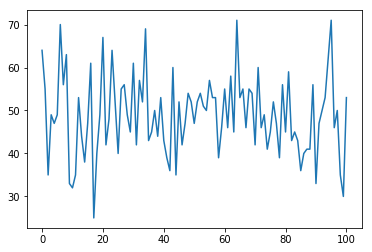

In [241]:
import matplotlib.pyplot as plt 

t = np.linspace(0, 100, num=101)
y = np.round(50 + 10*np.random.randn(t.size))

plt.plot(t, y)
plt.show()

In [248]:
sku2 = Item(K=100, h=0.35, U=7, S=25, L=10, period='W', length=101)
demand = np.array(y)
sku2.get_purchase_orders(demand);
sku2.get_inventory_levels(demand);
sku2.compute_costs(demand)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  32.,
        170.,   0.,   0.,   0., 173.,   0.,   0.,   0., 206.,   0.,   0.,
          0., 156.,   0.,   0., 205.,   0.,   0.,   0., 160.,   0.,   0.,
        209.,   0.,   0.,   0., 190.,   0.,   0.,   0., 170.,   0.,   0.,
          0., 141.,   0.,   0., 153.,   0.,   0., 157.,   0.,   0., 160.,
          0.,   0., 138.,   0.,   0., 204.,   0.,   0.,   0., 225.,   0.,
          0.,   0., 151.,   0.,   0., 196.,   0.,   0.,   0., 183.,   0.,
          0.,   0., 203.,   0.,   0.,   0., 164.,   0.,   0.,   0., 171.,
          0.,   0.,   0., 150.,   0.,   0., 179.,   0.,   0., 115.,   0.,
          0.,  53.]),
 array([ 32., 170.,   0.,   0.,   0., 173.,   0.,   0.,   0., 206.,   0.,
          0.,   0., 156.,   0.,   0., 205.,   0.,   0.,   0., 160.,   0.,
          0., 209.,   0.,   0.,   0., 190.,   0.,   0.,   0., 170.,   0.,
          0.,   0., 141.,   0.,   0., 153.,   0.,   0., 157.,   0.,   0.,
        160.,   

(array([116.,  61.,  26.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
        135.,  82.,  38.,   0., 126.,  65.,  40.,   0., 157.,  90.,  48.,
          0.,  92.,  40.,   0., 150.,  94.,  45.,   0.,  99.,  57.,   0.,
        157.,  88.,  45.,   0., 140.,  96.,  43.,   0., 131.,  95.,  35.,
          0.,  89.,  47.,   0.,  99.,  47.,   0., 105.,  51.,   0., 110.,
         53.,   0.,  85.,  46.,   0., 149., 103.,  45.,   0., 154., 101.,
         46.,   0.,  96.,  42.,   0., 136.,  90.,  41.,   0., 138.,  86.,
         39.,   0., 147., 102.,  43.,   0., 119.,  76.,  40.,   0., 130.,
         89.,  33.,   0., 103.,  53.,   0., 117.,  46.,   0.,  65.,  30.,
          0.,   0.]),
 array([116.,  61.,  26., -23., -47., -49., -70., -56., -63., -33.,   0.,
        135.,  82.,  38.,   0., 126.,  65.,  40.,   0., 157.,  90.,  48.,
          0.,  92.,  40.,   0., 150.,  94.,  45.,   0.,  99.,  57.,   0.,
        157.,  88.,  45.,   0., 140.,  96.,  43.,   0., 131.,  95.,  35.,
          0.,  8

70773.3


In [238]:
demand

array([55., 43., 59., 34., 48., 39., 60., 74., 48., 64., 48., 28.])

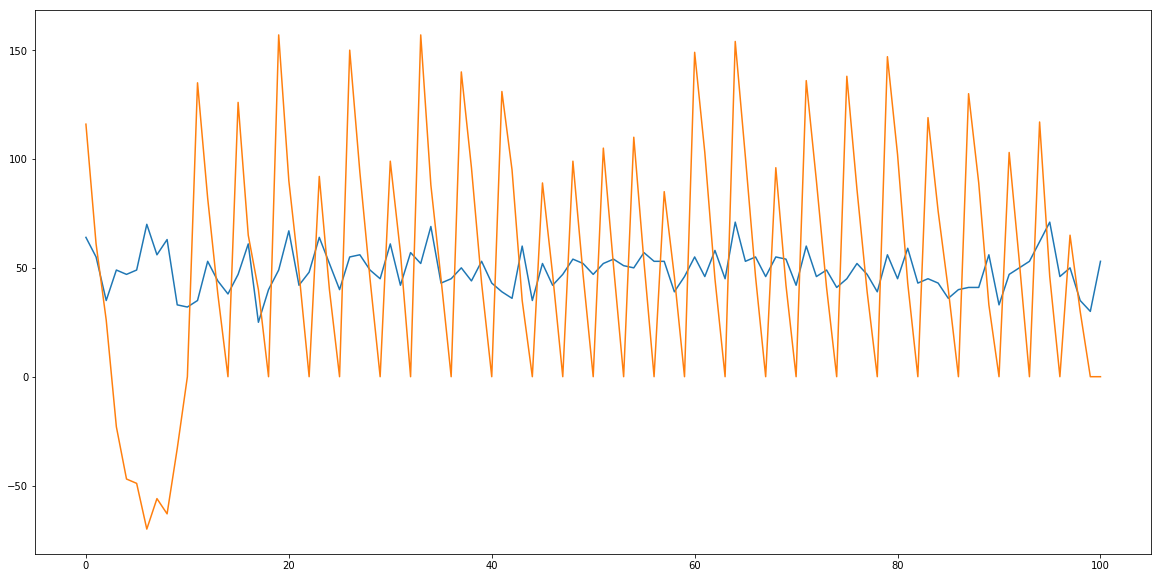

In [249]:
plt.figure(figsize=(20,10))
plt.plot(t, y, t, sku2.get_inventory_levels(demand)[1])